In [1]:
#
# This notebook implements a minimal cell-cycle oscillator defined by Equations 7-9
# in (Gerand, Tyson, and Novak, Biophys. J., 2013)
#
# The simple model is intended to give some insight into the oscillation mechanism,
# rather than describing the biochemical systems precisely
# 
# Since the biochemical details are different among Yeast, Xenopus, Droshophila, and mammals,
# it might be beneficial to investigate some common sub circuits
#

In [2]:
%matplotlib inline
import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt

In [3]:
#
# A 3-variable cell-cycle oscillator model
#
# state variable vector x = [Cdk/CyclinB complex (Cdk), Phosphorylated APC (APCp), securin (Sec)]
#
# Cdk phosphorylates APC, while Cdk is degraded by APCp.
# The negative feedback is widely considered as the primary mechanism for the oscillation.
# However, it is not sufficient. Generating oscillation requires a delay in the feedback.
# In this model, the delay is created by securin, which is also degraded though binding to APCp.
# Since securin has a larger binding affinity with APCp and thereby competitively inhibits Cdk/Cyclin B degradation,
# the negative feedback to Cdk through APCp gets delayed until securin degradation.
# This explains how this model exhibits the oscillation.
# Thus, if we use a weaker securin-APC binding affinity (i.e., larger K_dsec value, say, 0.01),
# the oscillation would vanishes.
#
# A note on model validity:
# Experiments on budding yeast and mouce have shown that securin is not essential for the cell-cycle oscillation. 
# Thus, this minimal model has been already rejected as the authors mentioned.
#　A current promising hypothesis for the delay is a bistable switch based on mutual inhibition between APC and APCpp,
# which is sometimes called the Kholodenko-type switch.
# However, this notebook avoids including the switch mechanism, because it would complicates the code.
#
#
# Parameter defiition
# Note that the notation is slightly modified from the paper to give better distinguishability on computer display
totalAPC = 1# = APC + APCp (Note that this model ignores multiple phospholyration)
V_scdk = 0.06# Spontaneous Cdk synthesis rate
d_d1cdk = 0.01# Spontaneous Cdk decay rate
d_dcdk = 0.35# APCp-dependent Cdk decay rate
K_dcdk = 0.01# Michaelis-Menten constant
V_2APC = 0.3#  etc.
K_2APC =0.01
V_1APC = 0.15
K_1APC = 0.01
V_ssec = 0.1
d_d1sec = 0.01
d_dsec = 0.4
K_dsec = 0.001
#
#model equations that define time derivatives of signal levels
def min_oscillator(x, time):
    Cdk = x[0]
    APCp = x[1]
    Sec = x[2]
    APC = totalAPC - APCp# assuming total APC amount is constant
    f = np.zeros((3,))
    MM1 = Cdk / (K_dcdk * (1 + (Sec / K_dsec)) + Cdk)# Michaelis-Menten with competitive inhibition formula
    MM2 = Sec / (K_dsec * (1 + (Cdk / K_dcdk)) + Sec)
    f[0] = V_scdk - d_d1cdk * Cdk - d_dcdk * APCp * MM1#  Eq. 7
    f[1] = V_2APC * Cdk * APC/(K_2APC + APC) - V_1APC * APCp /(K_1APC + APCp)# Eq. 8
    f[2] = V_ssec - d_d1sec * Sec - d_dsec * APCp * MM2# Eq. 9
    return f

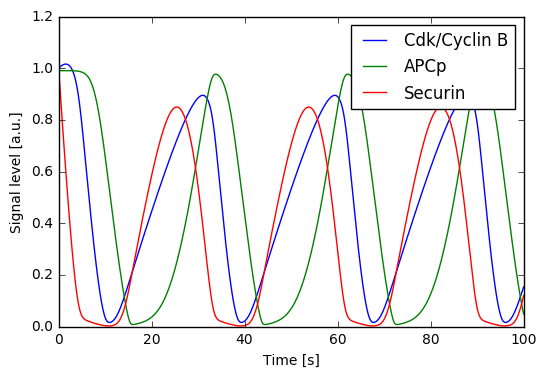

In [4]:
#
# Numetical integration.
# 'odeint'  uses Adams methods for non-stiff systems and backward differentiation formula methods for stiff systems.
#
time_points = np.linspace(0, 100, 1000)# define timepoints for ode solver
xinit = [1, 1, 1]
xvec = integrate.odeint(min_oscillator, xinit, time_points)
#
# Plot simulation result
#
plt.plot(time_points, xvec[:, 0], label='Cdk/Cyclin B')
plt.plot(time_points, xvec[:, 1], label='APCp')
plt.plot(time_points, xvec[:, 2], label='Securin')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Signal level [a.u.]')
plt.show()

In [5]:
#
# Rarely we have a single reliable set of biochemical parameter values.
# Furthermore, mutants may have different kinetics from the wildtype.
# Thus, we usually want to vary parameter values and observe the results,
# which is one of the most time-consuming steps in computational-biology studies.
#
# One classical technique to slightly save the effort is so-called bifurcation diagram:
# (0) choose a variable and parameter to focus, hereafter, X and P
# (1) numerically simulate the model with a parameter set
# (2) record the max and min values of X after reaching the steady-state
# (3) change P and repeat (1) and (2)
# (4) plot the result where x-axis shows P values and y-axis shows X values
# Below a piece of code demonstrates how the diagram helps
#
#
#
# Bifurcation diagram using APCp along with V_scdk
#
vs = np.logspace(-3, 0, num=100)# define V_scdk values to be examined (in the log scale)
APCp_max = np.zeros((100,))
APCp_min = np.zeros((100,))
time_points = np.linspace(0, 300, 3000)
xinit = [0.1, 0.1, 0.1]
for n, v in enumerate(vs):
    V_scdk = v
    xvec = integrate.odeint(min_oscillator, xinit, time_points)
    xinit = xvec[-1, :]
    APCp_max[n] = np.max(xvec[2000:, 1])
    APCp_min[n] = np.min(xvec[2000:, 1])
    if n%20 == 0:
        print("%d th parameter value examined." % n)

plt.plot(vs, APCp_max)
plt.plot(vs, APCp_min)
plt.xscale("log")
plt.xlabel('V_scdk')
plt.ylabel('APCp')
plt.show()
#
# We can see the V_scdk range of oscillatory dynamcis
#

0 th parameter value examined.
20 th parameter value examined.
40 th parameter value examined.
60 th parameter value examined.
80 th parameter value examined.
